<a href="https://colab.research.google.com/github/hafeez42/marketing_data_science/blob/master/Modeling_Customer_Churn_with_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import sqlite3
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
# import json file into colab
from google.colab import files
files.upload()

# setup Kaggle DIR; copy json file ; chmod
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

# verifying json file content
!ls -l ~/.kaggle
!cat ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
kaggle.json
total 4
-rw------- 1 root root 64 Jan 18 07:26 kaggle.json
{"username":"hafeez13","key":"f8f4ff99e0d6a812fd6a8fc27d6238d4"}

# Loading Data...

In [19]:
!kaggle datasets list -s e-commerce


ref                                                    title                                              size  lastUpdated          downloadCount  
-----------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
carrie1/ecommerce-data                                 E-Commerce Data                                     7MB  2017-08-17 02:44:30          75995  
nicapotato/womens-ecommerce-clothing-reviews           Women's E-Commerce Clothing Reviews                 3MB  2018-02-03 19:59:19          43705  
olistbr/brazilian-ecommerce                            Brazilian E-Commerce Public Dataset by Olist       43MB  2021-10-01 19:08:27         106270  
prachi13/customer-analytics                             E-Commerce Shipping Data                         121KB  2021-02-23 12:01:47          10620  
zusmani/pakistans-largest-ecommerce-dataset            Pakistan's Largest E-Commerce Dataset              

In [20]:
# download the dataset
!kaggle datasets download -d carrie1/ecommerce-data    

# unzip files
!unzip \*.zip

  0% 0.00/7.20M [00:00<?, ?B/s]
100% 7.20M/7.20M [00:00<00:00, 66.7MB/s]
Archive:  ecommerce-data.zip
  inflating: data.csv                


In [21]:
df = pd.read_csv('data.csv', engine='python')

df.head(20)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,12/1/2010 8:26,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,12/1/2010 8:26,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,12/1/2010 8:34,1.69,13047.0,United Kingdom


# Basic EDA

In [22]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [25]:
df.CustomerID.nunique()

4372

In [29]:
# create invoce month column
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['InvoiceMonth'] = df['InvoiceDate'].dt.to_period('M')

df['TotalSales'] = np.multiply(df.Quantity, df.UnitPrice)

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,TotalSales
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12,20.34


# Customer Lifetime Value
## calculate basic CLV

In [27]:
# monthly spend per customer
monthly_revenue = df.groupby(['CustomerID', 'InvoiceMonth'])['TotalSales'].sum()

# monthly average spend
monthly_revenue = np.mean(monthly_revenue)

# define lifespan
lifespan = 36 # months

# calculate basic CLV
clv_basic = monthly_revenue * lifespan

# print the basic CLV value
print('Average basic CLV is {:.1f} USD'.format(clv_basic))

Average basic CLV is 21850.3 USD


## calculate granular CLV


In [28]:
# calculate average revenue per invoice
revenue_per_purchase = df.groupby(['InvoiceNo'])['TotalSales'].mean().mean()

# calculate average number of unique invoices per customer per month
frequency_per_month = df.groupby(['CustomerID','InvoiceMonth'])['InvoiceNo'].nunique().mean()

# cefine lifespan to 36 months
lifespan_months = 36

# calculate granular CLV
clv_granular = revenue_per_purchase * frequency_per_month * lifespan_months

# Print granular CLV value
print('Average granular CLV is {:.1f} USD'.format(clv_granular))

Average granular CLV is 1183.6 USD


In [30]:
df[df.TotalSales < 0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,TotalSales
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom,2010-12,-27.50
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom,2010-12,-4.65
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom,2010-12,-19.80
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,2010-12,-6.96
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,2010-12,-6.96
...,...,...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397.0,United Kingdom,2011-12,-9.13
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498.0,United Kingdom,2011-12,-224.69
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311.0,United Kingdom,2011-12,-54.75
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315.0,United Kingdom,2011-12,-1.25


# RFM DataFrame

In [31]:
!pip install lifetimes
from lifetimes.utils import *

     |████████████████████████████████| 584 kB 4.8 MB/s 


In [32]:
summary = summary_data_from_transaction_data(df,'CustomerID','InvoiceDate',monetary_value_col='UnitPrice',)
summary.describe()

,frequency,recency,T,monetary_value
count,4372.000000,4372.000000,4372.000000,4372.000000
mean,3.413541,133.723010,225.304209,44.005153
std,6.674343,133.000474,118.384168,140.603924
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,115.000000,0.000000
50%,1.000000,98.000000,253.000000,23.123333
75%,4.000000,256.000000,331.000000,57.074375
max,145.000000,373.000000,373.000000,6253.205000


In [33]:
summary.head()

,frequency,recency,T,monetary_value
CustomerID,,,,
12346.0,0.0,0.0,325.0,0.000000
12347.0,6.0,365.0,367.0,65.270000
12348.0,3.0,283.0,358.0,43.036667
12349.0,0.0,0.0,18.0,0.000000
12350.0,0.0,0.0,310.0,0.000000


The summary function converted customer transactions into an aggregated table.Many of the customers have frequency, recency, and monetary = 0, like customer 12346. That's because Lifetimes only considers customers who have made repeat purchases into account.


Using days as time periods (can also be defined as weeks or months), variables are defined like so for the Lifetimes model:
 - **frequency**: # of days in which a customer made a repeat purchase
 - **T**: customer's age in days
 - **recency**: customer's age in days at time of most recent purchase
 - **monetary_value:** mean of a customer's purchases, excluding the 1st purchase



**frequency** excludes the customer's first purchase because that is considered the day the customer is born. Afterwards, you can begin to question whether or not that customer is alive.

In [ ]:
summary[summary['frequency']>0].head()

,frequency,recency,T,monetary_value
CustomerID,,,,
12347.0,6.0,365.0,367.0,65.270000
12348.0,3.0,283.0,358.0,43.036667
12352.0,6.0,260.0,296.0,357.125000
12356.0,2.0,303.0,325.0,37.345000
12358.0,1.0,149.0,150.0,64.580000


In [ ]:
df[df['CustomerID']==12437.0]['TotalSales'].value_counts()

30.00    19
10.20    16
19.80    11
17.40     8
30.60     7
         ..
31.20     1
6.64      1
12.75     1
13.50     1
40.80     1
Name: TotalSales, Length: 70, dtype: int64

# Vizualizig RFM DataFrame 
We’re going to use the Beta-Geometric/NBD (BG/NBD) model for customer churn. The BG/NBD model is an adaptation of the Pareto/NBD model. Both models describe repeat purchasing patterns in businesses where customer turnover is unobserved; however, the BG/NBD is much more computationally feasible.

In [ ]:
from lifetimes import BetaGeoFitter,GammaGammaFitter
from lifetimes.plotting import plot_probability_alive_matrix, plot_frequency_recency_matrix, plot_period_transactions, plot_cumulative_transactions,plot_incremental_transactions
from lifetimes.generate_data import beta_geometric_nbd_model
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases, plot_period_transactions,plot_history_alive

Assumptions of the BG/NBD model:
 - A customer’s relationship has two phases: “alive” for an unobserved period of time, then “dead”
 - While active, transactions made by a customer in time period t is Poisson distributed with mean λt
 - Heterogeneity in lambda follows a gamma distribution, meaning differences in transaction rate between customers follows a gamma distribution with shape r and scale α
 - Each customer becomes inactive after each transaction with probability p
 - the probability that a customer dies after a number of transactions follows a geometric distribution
 - differences in p follows a beta distribution with shape parameters a and b
 - Lambda and p vary independently across customers

### Example Poisson Distribution

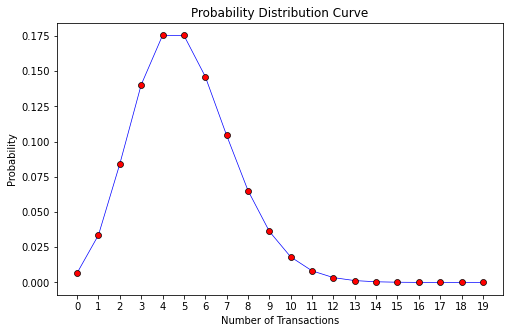

In [15]:
# making Poisson distributed variable with 100 observations
np.random.seed(42)
import matplotlib.pyplot as plt
from scipy.stats import poisson

probability_arr = []
distribution = poisson(5)
for transactions in range(0,20):
     probability_arr.append(distribution.pmf(transactions))

plt.figure(figsize=(8,5))
plt.ylabel('Probability')
plt.xlabel('Number of Transactions')
plt.xticks(range(0, 20))
plt.title('Probability Distribution Curve')
plt.plot(probability_arr, color='blue', linewidth=0.7, zorder=1)
plt.scatter(range(0, 20), probability_arr, color='red', edgecolor='black', linewidth=0.7, zorder=2)
plt.show()


### Example Gamma distribution

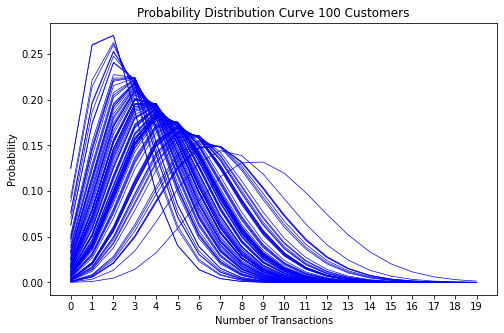

In [10]:
# making Gamma distrubuted variable with 100 observations
np.random.seed(42)
import numpy as np

plt.figure(figsize=(8,5))

for customer in range(0, 100):
    distribution = poisson(np.random.gamma(shape=9, scale=0.5))
    probability_arr = []
    for transactions in range(0,20):
        probability_arr.append(distribution.pmf(transactions))
    plt.plot(probability_arr, color='blue', linewidth=0.7, zorder=1)


plt.ylabel('Probability')
plt.xlabel('Number of Transactions')
plt.xticks(range(0, 20))
plt.title('Probability Distribution Curve 100 Customers')

plt.show()
plt.show()

### Example Beta Distribution

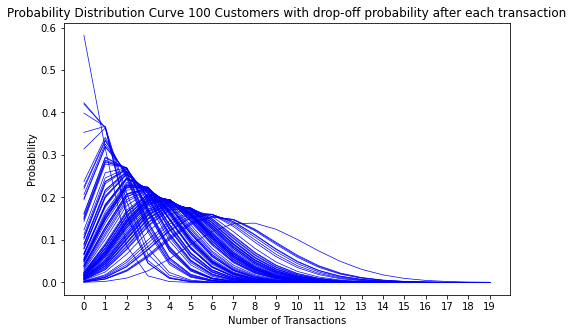

In [9]:
import numpy as np

plt.figure(figsize=(8,5))

for customer in range(0, 100):
    distribution = poisson(np.random.gamma(shape=9, scale=0.5))
    probability_arr = []
    beta = np.random.beta(a=1.0, b=2.5)
    cumulative_beta = 0
    for transactions in range(0,20):
        proba = distribution.pmf(transactions)
        cumulative_beta = beta + cumulative_beta - (beta * cumulative_beta)
        inactive_probability = 1 - cumulative_beta
        proba *= inactive_probability
        probability_arr.append(proba)
    probability_arr = np.array(probability_arr)
    probability_arr /= probability_arr.sum()
    plt.plot(probability_arr, color='blue', linewidth=0.7, zorder=1)


plt.ylabel('Probability')
plt.xlabel('Number of Transactions')
plt.xticks(range(0, 20))
plt.title('Probability Distribution Curve 100 Customers with drop-off probability after each transaction')

plt.show()

In [16]:
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(summary['frequency'], summary['recency'], summary['T'])

NameError: ignored

In [ ]:
plot_frequency_recency_matrix(bgf)

In [ ]:
plot_probability_alive_matrix(bgf)

# Training a model and evaluating model performance

Next we want to evaluate the model to see how well it performs in the future. I’ll split the data into a training (calibration) period and a holdout (observation) period, train the BG/NBD model and evaluate performance with four plots

### 1. Calibration period histogram: does the model fit the training data?



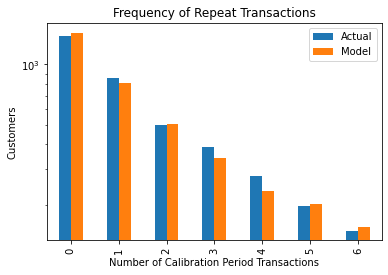

In [ ]:
plot_period_transactions(bgf).set_yscale('log')

The model is fairly representative of the real data up until four repeat transactions. There are few customers who make more purchases.

### 2. Cumulative transaction plot: does the model predict cumulative sales well?

In [ ]:
df.InvoiceDate.max()

Timestamp('2011-12-09 12:50:00')

In [ ]:
summary_cal_holdout = calibration_and_holdout_data(df, 'CustomerID', 'InvoiceDate',calibration_period_end='2011-01-01', observation_period_end='2011-12-08')

In [ ]:
summary_cal_holdout.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
CustomerID,,,,,
12347.0,0.0,0.0,25.0,6.0,341.0
12348.0,0.0,0.0,16.0,3.0,341.0
12370.0,1.0,3.0,18.0,2.0,341.0
12377.0,0.0,0.0,12.0,1.0,341.0
12383.0,0.0,0.0,10.0,5.0,341.0


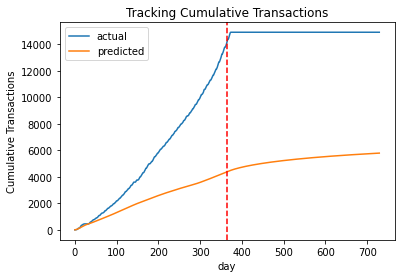

In [ ]:
bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_cumulative_transactions(bgf, df, 'InvoiceDate', 'CustomerID', 730, 365)

### 3. Incremental transaction plot: does the model capture the overall trend in transactions?

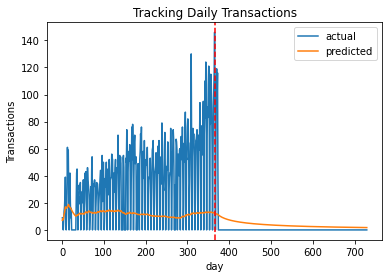

In [ ]:
plot_incremental_transactions(bgf, df, 'InvoiceDate', 'CustomerID', 730, 365)

In [ ]:
df.groupby('CustomerID').size().value_counts()

1      79
6      78
10     74
12     72
7      72
       ..
721     1
705     1
653     1
633     1
977     1
Length: 474, dtype: int64

#Churn 

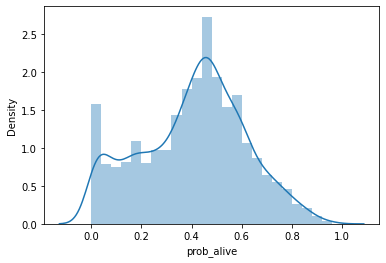

In [ ]:
df_churn = summary[summary['frequency']>0]
df_churn['prob_alive'] = bgf.conditional_probability_alive(df_churn['frequency'], df_churn['recency'], df_churn['T'])
sns.distplot(df_churn['prob_alive'])

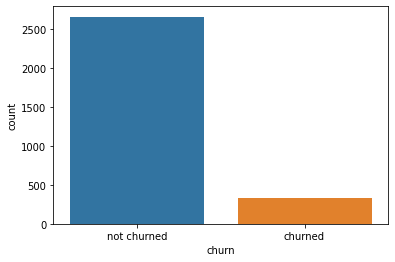

In [ ]:
df_churn['churn'] = ['churned' if p < .1 else 'not churned' for p in df_churn['prob_alive']]
sns.countplot(df_churn['churn'])


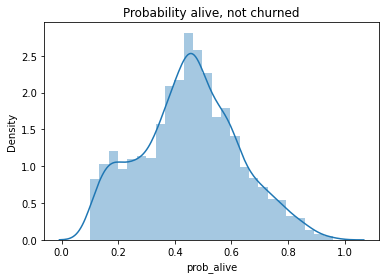

In [ ]:
sns.distplot(df_churn[df_churn['churn']=='not churned']['prob_alive']).set_title('Probability alive, not churned');

In [ ]:
df_churn['churn'][(df_churn['prob_alive']>=.1) & (df_churn['prob_alive']<.2)] = "high risk"
df_churn['churn'].value_counts()

not churned    2391
churned         331
high risk       269
Name: churn, dtype: int64